In [1]:
import tensorflow as tf
import os
import PIL.Image
import numpy as np
import IPython.display as display


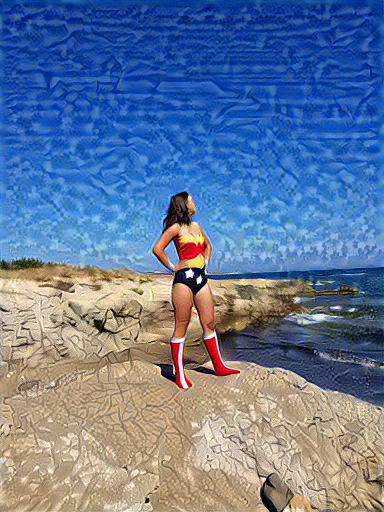

Train step: 10


In [2]:

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


class Singleton(type):
    __instances = {}
    
    def __call__(cls, *args, **kwargs):
        if cls not in cls.__instances:
            instance = super().__call__(*args, **kwargs)
            cls.__instances[cls] = instance
        return cls.__instances[cls]


class StyleContentExtractor(tf.keras.models.Model, metaclass=Singleton):
    def __init__(self, style_layers: list[str], content_layers: list[str], *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = self.__init_model(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
    
    def __init_model(self, layer_names: list[str]):
        base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        base_model.trainable = False
        outputs = [base_model.get_layer(name).output for name in layer_names]
        return tf.keras.Model([base_model.input], outputs)
        
    def call(self, inputs, input_max_value=1):
        content_outputs, style_outputs = self.__get_model_outputs(inputs, input_max_value)
        content_dict = dict(zip(self.content_layers, content_outputs))
        style_dict = dict(zip(self.style_layers, style_outputs))
        return {'content': content_dict, 'style': style_dict}
    
    def __get_model_outputs(self, inputs, input_max_value=tf.constant(1, tf.float16)):
        processed_input = self.__preprocess_input(inputs, input_max_value)
        outputs = self.model(processed_input)
        content_outputs = outputs[self.num_style_layers:]
        style_outputs = map(gram_matrix, outputs[:self.num_style_layers])
        return content_outputs, style_outputs
    
    def __preprocess_input(self, inputs, input_max_value):
        # self.__assert_max_value_not_exceeded(inputs, input_max_value)
        inputs = inputs * (255.0 / input_max_value)
        return tf.keras.applications.vgg19.preprocess_input(inputs)
    
    def __assert_max_value_not_exceeded(self, inputs, input_max_value):
        biggest_input = tf.reduce_max(inputs)
        if biggest_input > input_max_value:
            raise ValueError(f"Given tensor have values grater than {input_max_value = }, {biggest_input = }")
        
        
class NSTTrainer(tf.keras.models.Model):
    def __init__(self, style_image, content_image, style_layers: list[str], content_layers: list[str], content_weight=1e4, style_weight=1e-2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.extractor = StyleContentExtractor(style_layers, content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.style_targets = self.extractor(style_image)['style']
        self.content_targets = self.extractor(content_image)['content']
        self.__output_image = tf.Variable(content_image)
        self.style_weight = style_weight
        self.content_weight = content_weight
        
    def training_loop(self, steps_per_epoch, epochs):
        step = 0
        for _ in range(epochs):
            for _ in range(steps_per_epoch):
                step += 1
                self.train_step()
                print(".", end='', flush=True)
        display.clear_output(wait=True)
        display.display(self.output_image)
        print("Train step: {}".format(step))
    
    @tf.function()
    def train_step(self):
        with tf.GradientTape() as tape:
            outputs = self.extractor(self.__output_image)
            loss = self.style_content_loss(outputs)

        grad = tape.gradient(loss, self.__output_image)
        self.optimizer.apply_gradients([(grad, self.__output_image)])
        self.__output_image.assign(clip_0_1(self.__output_image))
        
    def style_content_loss(self, outputs):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) 
                            for name in style_outputs.keys()])
        style_loss *= self.style_weight / self.num_style_layers

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) 
                                for name in content_outputs.keys()])
        content_loss *= self.content_weight / self.num_content_layers
        loss = style_loss + content_loss
        return loss
                
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    @property
    def output_image(self):
        return tensor_to_image(self.__output_image)


content_image_path = os.path.join("images", "contents", "kamila_sea.jpg")
style_image_path = os.path.join("images", "styles", "hanji_sea.jpg")
content_image = load_img(content_image_path)
style_image = load_img(style_image_path)
        
        
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


model = NSTTrainer(style_image, content_image, style_layers, content_layers)
model.compile(tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)) # LBFGS do obczajenia
model.training_loop(epochs=1, steps_per_epoch=10)



In [3]:
k = [1, 2, 3]
v = [4, 5, 6]
dict(zip(k,v))
list(map(lambda x: -x, k))

[-1, -2, -3]

AttributeError: type object 'Singleton' has no attribute '__instances'

True